# Testing Classifier class

In [1]:
import os
os.environ['SPS_HOME'] = "/global/homes/e/eramey16/fsps"
import sqlalchemy as sa
from sqlalchemy.pool import NullPool
import pandas as pd
import importlib
import logging
import db_util as util

In [2]:
meta = sa.MetaData()

In [3]:
engine = sa.create_engine(util.conn_string, poolclass=NullPool)

bk_tbl = sa.Table('bookkeeping', meta, autoload_with=engine)
gal_tbl = sa.Table('dr10_training', meta, autoload_with=engine)

In [4]:
[x.name for x in gal_tbl.columns.values()]

['ls_id',
 'ra',
 'dec',
 'type',
 'dered_mag_g',
 'dered_mag_r',
 'dered_mag_i',
 'dered_mag_z',
 'dered_mag_w1',
 'dered_mag_w2',
 'dered_flux_g',
 'dered_flux_r',
 'dered_flux_i',
 'dered_flux_z',
 'dered_flux_w1',
 'dered_flux_w2',
 'g_r',
 'i_z',
 'r_i',
 'r_z',
 'w1_w2',
 'z_w1',
 'snr_g',
 'snr_r',
 'snr_i',
 'snr_z',
 'snr_w1',
 'snr_w2',
 'flux_ivar_g',
 'flux_ivar_r',
 'flux_ivar_i',
 'flux_ivar_z',
 'flux_ivar_w1',
 'flux_ivar_w2',
 'dchisq_1',
 'dchisq_2',
 'dchisq_3',
 'dchisq_4',
 'dchisq_5',
 'rchisq_g',
 'rchisq_r',
 'rchisq_i',
 'rchisq_z',
 'rchisq_w1',
 'rchisq_w2',
 'sersic',
 'sersic_ivar',
 'psfsize_g',
 'psfsize_r',
 'psfsize_z',
 'shape_r',
 'shape_e1',
 'shape_e2',
 'shape_r_ivar',
 'shape_e1_ivar',
 'shape_e2_ivar',
 'z_phot_median',
 'z_phot_std',
 'z_spec',
 'maggies_0',
 'maggies_1',
 'maggies_2',
 'maggies_3',
 'maggies_4',
 'maggies_5',
 'maggies_unc_0',
 'maggies_unc_1',
 'maggies_unc_2',
 'maggies_unc_3',
 'maggies_unc_4',
 'maggies_unc_5',
 'maggies_fi

In [5]:
stmt = sa.select(bk_tbl).where(bk_tbl.c.ls_id==10995549460239206)
with engine.connect() as conn:
    bk_data = pd.DataFrame(conn.execute(stmt))

In [6]:
from docker.classify import Classifier

In [10]:
classy = Classifier(logger=logging.DEBUG)
x1, x2 = classy.get_galaxy(ls_id=10995426317567295)

NameError: name 'logging' is not defined

In [8]:
gal_data = classy.query_galaxy(ls_id=10995426316525910)

In [9]:
classy.run_prospector(gal_data.iloc[0], outfile='test.h5')

Loaded observation
Loaded SPS libraries


# Prepping new run of DR10 data:
4/8/24

### Updated 11/25/24 with LRGS

In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ['SPS_HOME'] = "/global/homes/e/eramey16/fsps"
from docker import classify
from docker import db_util

import sqlalchemy as sa
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
lrg_file = os.path.expandvars("$PSCRATCH/data/monocle/LRGs/lensed_LRGs.dat")
command_file = os.path.expandvars("$PSCRATCH/data/monocle/LRGs/lensed_LRG_job.sl")

header = """#!/bin/bash
#SBATCH -C cpu
#SBATCH -N 1
#SBATCH --licenses=cfs,SCRATCH
#SBATCH -q regular
#SBATCH -t 20:00:00
#SBATCH -A m2218
#SBATCH --image=eramey16/monocle:latest --volume=/pscratch/sd/e/eramey16/data/monocle/LRGs:/monocle/exports

"""

lrgs = pd.read_csv(lrg_file)
stmt = "srun -n 32 shifter python $HOME/galactic_lenses/docker/classify.py -t lensed_LRG --train -tn lrg_train -l "
lrg_commands = stmt + lrgs.ls_id.astype(str)
# num_files = int(len(lrg_commands)/25)
# idxs = np.linspace(0, len(lrg_commands), num_files+1).astype(int)
# for i in range(num_files):
#     short_commands = lrg_commands.iloc[idxs[i]:idxs[i+1]]
    # short_commands.to_csv(command_file+f"_{i}.sh", index=False, header=False)
# lrg_commands.to_csv(command_file, index=False, header=False)
# with open(command_file, 'w') as file:
#     file.write(header+'\n'.join(lrg_commands))

In [3]:
classy = classify.Classifier()
unused_lsids = []
for ls_id in lrgs.ls_id:
    try:
        bkdata, tbldata = classy.get_galaxy(ls_id, tag='lensed_LRG')
        if bkdata.stage[0]!=2: unused_lsids.append(ls_id)
    except:
        unused_lsids.append(ls_id)
len(unused_lsids)

Failed to start MPI; are mpi4py and schwimmbad installed?Proceeding without MPI.
Message: libmpi.so.12: cannot open shared object file: No such file or directory


NameError: name 'time' is not defined

In [3]:
len(lrgs)

756

In [ ]:
# ----------------------------------------------

In [2]:
all_lensed = []
path = os.path.expandvars("$PSCRATCH/data/monocle/test_data")
for grade in ['A', 'B', 'C']:
    data1 = pd.read_csv(f'{path}/masterlens_{grade}.tsv',sep='\t', header=1)
    data1.columns = [x.replace('"', '').replace(' ', '').replace('#', '') 
                    for x in data1.columns]
    data1['grade'] = grade
    data1['source'] = 'MLD'
    data1['ra'] = data1.ra_coord
    data1['dec'] = data1.dec_coord
    all_lensed.append(data1[['ra', 'dec', 'sdss_specObjID', 'grade']])
    
    data2 = pd.read_csv(f'{path}/H21_{grade}.csv')
    data2.columns = [x.lower() for x in data2.columns]
    data2 = data2.loc[:,~data2.columns.duplicated()].copy()
    data2['grade'] = grade
    data2['source'] = 'H21'
    all_lensed.append(data2[['ra', 'dec', 'grade']])
all_lensed = pd.concat(all_lensed, ignore_index=True)

In [3]:
all_lensed

,ra,dec,sdss_specObjID,grade
0,2.012310,-0.068960,"""753269961564121088""",A
1,3.609417,-30.382194,"""""",A
2,5.670492,14.519565,"""847857093141620736""",A
3,6.347931,-12.328680,"""""",A
4,7.282400,-0.930710,"""440251082728302592""",A
...,...,...,...,...
1695,358.699900,5.044700,NaN,C
1696,359.142110,2.692200,NaN,C
1697,359.721700,1.401800,NaN,C
1698,359.883090,-2.260100,NaN,C


In [4]:
data1 = pd.read_csv(f'{path}/masterlens_A.tsv',sep='\t', header=1)
print(data1.iloc[0])
classy = classify.Classifier()
q = classy.send_query(where='id1=10995462702105255', cols=['id1', 'id2', 'ra1', 'ra2'],
                  tbl='ls_dr10.x1p5__tractor__sdss_dr17__specobj')
trac_data = classy.query_galaxy(all_lensed.ra[0], all_lensed.dec[0])
q.id2[0]==int(all_lensed.sdss_specObjID[0].strip().replace('"', ''))

# "system_name"                                 SDSS J0008-0004
 "discovery_date"                                  "2008-08-01"
 "alternate_name"                                            ""
 "kind_acronym"                                       "GAL-GAL"
 "discovery_acronym"                                    "SLACS"
 "reference_identifier"                       "ApJ682(2008)964"
 "ra_hrs"                                                  "00"
 "ra_mins"                                                 "08"
 "ra_secs"                                               "2.96"
 "ra_coord"                                             2.01231
 "dec_degrees"                                            "-00"
 "dec_arcmin"                                              "04"
 "dec_arcsec"                                            "8.26"
 "dec_coord"                                           -0.06896
 "lensgrade"                                                "A"
 "number_images"                        

True

In [5]:
not_found = []
wrong_match = []
match = 0
classy = classify.Classifier()
for i,gal in all_lensed.iterrows():
    try:
        trac_data = classy.query_galaxy(ra=gal.ra, dec=gal.dec)
        all_lensed.loc[i, trac_data.columns] = trac_data.iloc[0]
        q = classy.send_query(where=f'id1={trac_data.ls_id[0]}', cols=['id1', 'id2', 'ra1', 'ra2'],
                          tbl='ls_dr10.x1p5__tractor__sdss_dr17__specobj')
        specObjID = str(all_lensed.sdss_specObjID[i]).strip().replace('"', '')
        if not q.empty and specObjID.isnumeric():
            match += 1
            if q.id2[0] != int(specObjID):
                wrong_match.append([i, specObjID, q.id2[0]])
    except Exception as e:
        # print(e)
        not_found.append(i)
# all_lensed.drop(index=wrong_match+not_found, inplace=True)

In [6]:
wrong_match

[[15, '747628086064867328', 8087531557089466368],
 [16, '4060181793113306112', 4060181793114183680],
 [17, '788135469241100288', 4765971230724741120],
 [26, '4939387580472292352', 4939387580473169920],
 [27, '4939380983402525696', 4939380983403403264],
 [159, '337839273883494400', 337836245579229184],
 [233, '4859467928053412864', 4859467928054290432],
 [249, '433492386346199040', 433489910867978240],
 [487, '4240324679216591872', 4240324679217469440],
 [529, '4866272255728350208', 4866272255729227776],
 [761, '4258294548025242624', 4258294548026120192],
 [765, '4260470481956041728', 4260470481956919296],
 [766, '4315604393371563008', 4315604393372440576],
 [794, '4564620688459494400', 4564620688460371968]]

In [7]:
wrong_gal = all_lensed.iloc[15]
wrong_gal['dered_mag_z']

16.315226

In [8]:
len(wrong_match)/match, len(not_found)

(0.17721518987341772, 355)

In [9]:
# lrgs = all_lensed.drop(index=not_found)
# g, r, z = lrgs.dered_mag_g, lrgs.dered_mag_r, lrgs.dered_mag_z
# w1, w2 = lrgs.dered_mag_w1, lrgs.dered_mag_w2
# cut1 = (z - w1) > (0.8 * (r - z) - 0.6)
# cut2 = ((g - w1) > 2.9) | ((r - w1) > 1.8)
# cut3 = (((r-w1) > 1.8*(w1-17.14)) & ((r-w1) > (w1-16.33))) | ((r-w1) > 3.3)
# print(len(lrgs[cut1 & cut2 & cut3]), len(lrgs))
# lrgs = lrgs[cut1 & cut2 & cut3]
# lrgs['ls_id'] = lrgs['ls_id'].astype(int)
# path = os.path.expandvars("$SCRATCH/data/monocle/LRGs")
# lrgs[['ls_id']].to_csv(f"{path}/lensed_LRGs.dat", index=False)

756 1345


In [ ]:
# found_lensed = all_lensed.drop(index=not_found)
# found_lensed['ls_id'] = found_lensed['ls_id'].astype(int)
# path = os.path.expandvars("$SCRATCH/data/monocle/LRGs")
# found_lensed[['ls_id']].to_csv(f"{path}/lensed_all.dat", index=False)
# found_lensed.columns, len(found_lensed)

In [25]:
found_lensed.replace([np.inf, -np.inf], np.nan, inplace=True)
found_lensed.loc[found_lensed.z_phot_median<0, 'z_phot_median'] = np.nan

In [30]:
len(found_lensed[np.isnan(found_lensed.dered_mag_i)])

225

In [7]:
clean_lensed = util.clean_and_calc(found_lensed, mode='dr10')
clean_lensed['lens_grade'] = clean_lensed['grade']
use_cols = [col.name for col in util.db_cols if col.name in clean_lensed.columns]
clean_lensed = clean_lensed[use_cols]

In [9]:
engine = create_engine(util.conn_string)
util.bookkeeping_setup('dr10_training', data=clean_lensed, train=True,
                       tag='lensed_original', engine=engine)

In [1]:
import os
os.environ['SPS_HOME'] = "/global/homes/e/eramey16/fsps"
from docker import classify, util
import sqlalchemy
from sqlalchemy.pool import NullPool

In [2]:
engine = sqlalchemy.create_engine(util.conn_string, poolclass=NullPool)
bkdata, tbldata = classify.get_galaxy(10995435681361334, engine=engine)

In [3]:
h5_file = '/pscratch/sd/e/eramey16/data/monocle/test/10995435681361334.h5'
data = classify.merge_prospector(tbldata, h5_file)

Object found: 10995435681361334
Redshift: 0.17203856
> /global/u1/e/eramey16/galactic_lenses/docker/classify.py(203)merge_prospector()
    201     import pdb; pdb.set_trace()
    202     # Run Prospector
--> 203     if h5_file is None: h5_file = f'{output_dir}/{basic_data.ls_id}.h5'
    204     if redo or not os.path.exists(h5_file):
    205         h5_file = run_prospector(basic_data.ls_id, mags, mag_uncs, outfile=h5_file)



ipdb>  c


In [ ]:
classify.update_db(bkdata, data, engine=engine)

['ls_id', 'ra', 'dec', 'type', 'dered_mag_g', 'dered_mag_r', 'dered_mag_i', 'dered_mag_z', 'dered_mag_w1', 'dered_mag_w2', 'dered_flux_g', 'dered_flux_r', 'dered_flux_i', 'dered_flux_z', 'dered_flux_w1', 'dered_flux_w2', 'g_r', 'i_z', 'r_i', 'r_z', 'w1_w2', 'z_w1', 'snr_g', 'snr_r', 'snr_i', 'snr_z', 'snr_w1', 'snr_w2', 'flux_ivar_g', 'flux_ivar_r', 'flux_ivar_i', 'flux_ivar_z', 'flux_ivar_w1', 'flux_ivar_w2', 'dchisq_1', 'dchisq_2', 'dchisq_3', 'dchisq_4', 'dchisq_5', 'rchisq_g', 'rchisq_r', 'rchisq_i', 'rchisq_z', 'rchisq_w1', 'rchisq_w2', 'sersic', 'sersic_ivar', 'psfsize_g', 'psfsize_r', 'psfsize_z', 'shape_r', 'shape_e1', 'shape_e2', 'shape_r_ivar', 'shape_e1_ivar', 'shape_e2_ivar', 'z_phot_median', 'z_phot_std', 'z_spec', 'maggies_0', 'maggies_1', 'maggies_2', 'maggies_3', 'maggies_4', 'maggies_5', 'maggies_unc_0', 'maggies_unc_1', 'maggies_unc_2', 'maggies_unc_3', 'maggies_unc_4', 'maggies_unc_5', 'maggies_fit_0', 'maggies_fit_1', 'maggies_fit_2', 'maggies_fit_3', 'maggies_fit_4

# Older:

In [1]:
import os
os.environ['SPS_HOME'] = "/global/homes/e/eramey16/fsps"

from docker import classify
from docker import util
import numpy as np
import pandas as pd

from prospect.io import read_results as reader
from prospect.plotting import corner
from prospect.plotting.utils import best_sample

import matplotlib.pyplot as plt
import matplotlib as mpl

from sqlalchemy import create_engine

file1 = "dr10_lensed_param_csp.h5"
file2 = "dr10_unlensed_param_csp.h5"
file3 = '/global/homes/e/eramey16/galactic_lenses/160411A_1695693223_mcmc.h5' # Test galaxy
test = '160411A_1695844597_mcmc.h5' # Test galaxy 2?
lensed_h5 = '160411A_1695850628_mcmc.h5' # Lensed
unlensed_h5 = '160411A_1695854467_mcmc.h5' # Unlensed

In [2]:
res, obs, model = reader.results_from('/pscratch/sd/e/eramey16/data/monocle/test/10995435681361334.h5')

In [8]:
res['theta_labels']

['zred', 'dust2', 'tau', 'tmax', 'massmet_1', 'massmet_2']

In [2]:
# from importlib import reload
# reload(util)

In [3]:
iptf16 = {
    'ls_id': 9906619143751091,
    'ra': 316.066215680906,
    'dec': -6.34022115158153
}
unlensed = {
    'ls_id': 10995426317568050,
    'ra': 316.060774,
    'dec': -6.302004
}

bands = ['g', 'r', 'i', 'z', 'w1', 'w2']

In [4]:
engine = create_engine(util.conn_string)
conn = engine.connect()

existing_lensed = pd.DataFrame(conn.execute("SELECT * from dr10_training"))
conn.close()
existing_lensed

,index,ls_id,ra,dec,type,mag_g,mag_r,mag_i,mag_z,mag_w1,...,shape_e2,shape_r_ivar,shape_e1_ivar,shape_e2_ivar,g_r,i_z,r_i,r_z,w1_w2,z_w1
0,0,9907733236354151,148.167589,34.579482,SER,20.399717,18.644474,-9999.000000,17.807503,17.247543,...,-0.048564,1542.1370,38140.980,17938.459,1.755243,-9999.000000,-9999.000000,0.836971,-0.491598,0.559959
1,1,9907733471628447,159.437614,35.291928,SER,18.096481,17.024176,-9999.000000,16.307621,16.526682,...,-0.173974,186381.8300,1220171.100,964398.750,1.072306,-9999.000000,-9999.000000,0.716555,-0.403765,-0.219061
2,2,9907733789017013,207.292927,36.211078,SER,20.823143,19.237059,-9999.000000,18.165255,17.457613,...,-0.017785,4359.8647,43034.668,17416.707,1.586084,-9999.000000,-9999.000000,1.071804,-0.431957,0.707642
3,3,9907734085042819,173.778665,37.339953,SER,18.771824,17.558838,-9999.000000,16.808851,16.804546,...,-0.268674,87221.4100,983132.000,700901.940,1.212986,-9999.000000,-9999.000000,0.749987,-0.465199,0.004305
4,4,9907734743679373,128.963589,39.439312,SER,17.981194,16.431450,-9999.000000,15.622113,15.512491,...,-0.065923,27576.8180,1109161.200,1122406.200,1.549744,-9999.000000,-9999.000000,0.809337,-0.405940,0.109622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586,586,10995620540061348,125.676331,26.878766,SER,18.720839,17.340942,16.873960,16.573694,16.445631,...,0.008575,30993.5740,504637.620,257349.810,1.379896,0.300266,0.466982,0.767248,-0.369413,0.128063
587,587,10995620774938387,188.215482,27.035860,DEV,21.338257,19.970604,19.274855,18.965378,18.368814,...,-0.026731,2931.2163,15228.007,6248.034,1.367653,0.309477,0.695749,1.005226,-0.584936,0.596563
588,588,10995622864752736,27.503598,27.426738,SER,18.779850,17.189816,inf,16.297482,16.005095,...,-0.163916,1867.5847,126868.120,301990.200,1.590035,inf,inf,0.892334,-0.457623,0.292387
589,589,10995624982874123,236.264898,27.801471,DEV,21.265585,19.499271,inf,18.241259,17.347088,...,-0.113486,1209.4319,9722.108,8771.155,1.766314,inf,inf,1.258013,-0.494162,0.894171


In [5]:
# lensed_dr10 = []
# for _,gal in existing_lensed.iterrows():
#     try:
#         df = classify.query_galaxy(ra=gal.ra, dec=gal.dec)
#     except: continue
#     lensed_dr10.append(df)
# lensed_dr10 = pd.concat(lensed_dr10, ignore_index=True)
# lensed_dr10

In [6]:
# lens = util.clean_and_calc(lensed_dr10, mode='dr9')

In [7]:
trac = classify.query_galaxy(iptf16['ra'], iptf16['dec'])
trac

,ls_id,ra,dec,type,dered_mag_g,dered_mag_r,dered_mag_i,dered_mag_z,dered_mag_w1,dered_mag_w2,...,psfsize_z,shape_r,shape_e1,shape_e2,shape_r_ivar,shape_e1_ivar,shape_e2_ivar,z_phot_median,z_phot_std,z_spec
0,10995426317568240,316.066181,-6.340227,SER,20.144327,18.742605,18.173893,17.796282,17.236155,17.585125,...,1.23741,0.685131,-0.10054,0.12557,398434.78,187633.05,224447.33,0.298457,0.057293,-99


In [8]:
# list(trac[['dered_mag_'+b for b in bands]].iloc[0])

In [9]:
# lens10 = lens[(lens.z_phot_median > .15) & (lens.z_phot_median < .25)]
# lens10['mag_diff'] = np.abs(trac.dered_mag_r[0] - lens10.dered_mag_r)
# lens10 = lens10.sort_values(by='mag_diff', ignore_index=True)
# lens10 = lens10.iloc[:10]
# lens10.to_csv('test_lensed.csv', index=False)
lens10 = pd.read_csv('test_lensed.csv')
lens10

,brickid,brickname,objid,ls_id,ra,dec,type,mag_g,mag_r,mag_i,...,flux_sigma_g,flux_sigma_r,flux_sigma_i,flux_sigma_z,flux_sigma_w1,flux_sigma_w2,min_dchisq,sum_rchisq,abs_mag_r,mag_diff
0,304607,0364m045,11702,10995435681361334,36.529823,-4.457322,SER,19.631344,18.470120,18.060210,...,0.022245,0.031936,0.063435,0.060315,0.679330,1.336214,3553109.50,7.049488,-20.926210,0.330570
1,318955,0268m020,577,10995450726318657,26.762113,-1.952628,REX,19.698849,19.260143,19.076800,...,0.040861,0.049608,0.112444,0.121509,0.562796,1.292103,0.00,7.906711,-20.646644,0.450169
2,300290,0342m052,2383,10995431154649423,34.144323,-5.176412,DEV,20.741240,19.406576,18.960188,...,0.019258,0.032507,0.046689,0.061152,0.627720,1.281308,856591.40,8.321031,-20.699594,0.619162
3,404024,1901p127,101,10995539927629925,189.988468,12.669337,SER,19.264034,17.944952,17.486988,...,0.100553,0.204341,0.222757,0.388659,1.061135,2.016527,355844.56,7.190876,-22.071844,0.883911
4,389849,1775p102,2942,10995525064067966,177.570915,10.281381,SER,18.743723,17.682434,17.192823,...,0.085076,0.160373,0.224532,0.224266,1.103721,2.029197,957131.40,12.561771,-22.424747,1.113678
5,416656,1997p150,4627,10995553173246483,199.885388,15.073887,DEV,18.749310,17.605726,17.160040,...,0.080001,0.184260,0.202270,0.261892,0.906196,1.592718,1040603.90,14.294401,-21.555905,1.186701
6,388308,1466p100,4377,10995523448213785,146.736170,10.114695,SER,18.924840,17.611118,17.128750,...,0.095186,0.217147,0.182677,0.393823,1.059624,1.879925,689400.50,18.820649,-22.332974,1.194494
7,331211,2108p000,3485,10995463577669021,210.872859,0.111497,SER,18.853970,17.647707,17.189943,...,0.058203,0.129803,0.182992,0.256875,0.930822,1.660837,1161610.00,15.391824,-21.953701,1.197575
8,318179,1928m022,4437,10995449912627541,192.898767,-2.134761,SER,18.732760,17.579939,17.125818,...,0.088106,0.182933,0.416082,0.405782,1.136341,2.171324,421251.70,15.532900,-22.007326,1.210335
9,315414,2216m027,821,10995447013311285,221.510959,-2.807735,SER,18.935795,17.637444,17.157036,...,0.049386,0.076263,0.213026,0.139972,1.021730,1.878905,2424170.50,12.087793,-22.282556,1.279279


In [10]:
unlens10 = pd.read_csv('test_unlensed.csv')
unlens10

,brickid,brickname,objid,ls_id,ra,dec,type,mag_g,mag_r,mag_i,...,flux_sigma_g,flux_sigma_r,flux_sigma_i,flux_sigma_z,flux_sigma_w1,flux_sigma_w2,min_dchisq,sum_rchisq,abs_mag_r,mag_diff
0,295677,3161m062,1343,10995426317567295,316.038729,-6.297523,DEV,20.810173,19.368470,18.840206,...,0.038928,0.060445,0.232419,0.083241,0.649896,1.318726,319620.80,4.990122,-20.762335,0.004896
1,295676,3158m062,7612,10995426316524988,315.961088,-6.365928,SER,20.446207,19.366510,18.929073,...,0.037610,0.055965,0.280426,0.088615,0.627884,1.317206,180325.40,5.301320,-20.976581,0.009146
2,295677,3161m062,7351,10995426317573303,316.195760,-6.312269,SER,20.652534,19.282745,18.802452,...,0.033929,0.052353,0.120034,0.080376,0.656273,1.365211,435534.80,4.187056,-20.832114,0.079670
3,294244,3158m065,10835,10995424814967379,315.952663,-6.380382,REX,20.665163,19.600750,19.221802,...,0.032404,0.047742,0.231246,0.074947,0.604190,1.277290,0.00,4.850978,-19.763474,0.220372
4,295677,3161m062,565,10995426317566517,316.018369,-6.355876,EXP,20.385134,19.628162,19.251608,...,0.041142,0.063491,0.309040,0.104598,0.589311,1.292966,79989.94,4.267848,-20.134691,0.267013
5,295677,3161m062,1892,10995426317567844,316.054864,-6.357613,SER,20.760756,19.642666,19.236465,...,0.032106,0.053075,0.220553,0.080206,0.590986,1.269469,162362.89,4.057378,-19.776393,0.285787
6,295676,3158m062,6585,10995426316523961,315.932946,-6.360123,REX,20.319427,19.700432,19.894617,...,0.037215,0.057064,14.379735,0.092864,0.568114,1.266556,0.00,4.153965,-19.863341,0.317644
7,295677,3161m062,6835,10995426317572787,316.182677,-6.286943,SER,20.582184,19.692732,19.294233,...,0.036575,0.050907,0.249799,0.079969,0.585609,1.275393,136136.05,4.086779,-20.324893,0.334865
8,295676,3158m062,8534,10995426316525910,315.986994,-6.290768,SER,21.013552,19.748901,19.300343,...,0.034497,0.049869,0.232531,0.077721,0.754735,1.406042,159718.33,4.946516,-20.475143,0.380205
9,295677,3161m062,6702,10995426317572654,316.178677,-6.282928,SER,21.133589,19.765564,19.233837,...,0.033115,0.047980,0.231055,0.075604,0.610257,1.272937,176523.05,4.627526,-20.369026,0.408442


In [11]:
# filters = [f'dered_mag_{x}' for x in bands]
# sig_f = np.array([(trac['flux_ivar_'+b])**-.5 for b in bands])
# f = np.array([trac['dered_flux_'+b] for b in bands])
# sig_m = 2.5 / np.log(10) * sig_f / f
# list(sig_m.ravel())

In [12]:
# trac = classify.query_galaxy(unlensed['ra'], unlensed['dec'])
# trac

In [13]:
# list(trac[['dered_mag_'+b for b in bands]].iloc[0])

In [14]:
# 2.5 / np.log(10) / np.array([trac['snr_'+b][0] for b in bands])

In [15]:
# data = classify.query_galaxy(iptf16['ra'], iptf16['dec'], radius=.5, limit=10000)
# data = util.clean_and_calc(data, mode='dr9')
# data = data[(data['z_phot_median']>.15) & (data['z_phot_median']<.25)]
# data['mag_diff'] = np.abs(trac.dered_mag_r[0] - data.dered_mag_r)
# data = data.sort_values(by='mag_diff', ignore_index=True).dropna(subset=['z_phot_median']+
#                                                                  [f'dered_mag_{b}' for b in bands]+
#                                                                  [f'snr_{b}' for b in bands]
#                                                                 )
# data.iloc[:10].to_csv("test_galaxies.csv", index=False)
data = pd.read_csv("test_unlensed.csv")

In [16]:
gal10 = unlens10
# gal10 = classify.query_galaxy(iptf16['ra'], iptf16['dec'])
for i,gal in gal10.iterrows():
    print(f"mpirun -n 50 python param_monocle.py --mag_in=\"{list(gal[['dered_mag_'+b for b in bands]])}\" " \
          f"--mag_unc_in=\"{list(2.5 / np.log(10) / np.array([gal['snr_'+b] for b in bands]))}\" " \
          f" --outfile=test_data/unlensed_param_1{i}")

mpirun -n 50 python param_monocle.py --mag_in="[20.534489, 19.182764, 18.703651, 18.394587, 18.363373, 18.889431]" --mag_unc_in="[0.008913583930684145, 0.0036683573752172636, 0.008671173615898023, 0.0022669790110845865, 0.015857327149587933, 0.05194314836927201]" --object_redshift=0.227508 --outfile=test_data/unlensed_param_10
mpirun -n 50 python param_monocle.py --mag_in="[20.152586, 19.168722, 18.783634, 18.547226, 18.544859, 18.851109]" --mag_unc_in="[0.006159053280972798, 0.003390368454462376, 0.01135460233902791, 0.0027949578570812977, 0.01812471018680298, 0.05011304505445599]" --object_redshift=0.249481 --outfile=test_data/unlensed_param_11
mpirun -n 50 python param_monocle.py --mag_in="[20.378567, 19.098198, 18.666746, 18.373539, 18.40185, 18.806282]" --mag_unc_in="[0.006719014720681173, 0.0029360322316160114, 0.004325220067197144, 0.0021456341679140377, 0.01658909261526765, 0.04980691254680989]" --object_redshift=0.225964 --outfile=test_data/unlensed_param_12
mpirun -n 50 pytho

In [17]:
# data = pd.DataFrame(columns=['name', 'z', 'filters', 'maggies', 'maggies_unc'],
#                     index=range(len(gal10)))
# sdss = ['sdss_{}0'.format(b) for b in ['g','r','i','z']]
# wise = ['wise_w1', 'wise_w2']
# filternames = sdss + wise

# for i,gal in gal10.iterrows():
#     M_AB = np.array(gal[['dered_mag_'+b for b in bands]])
#     M_AB_unc = 2.5 / np.log(10) / np.array([gal['snr_'+b] for b in bands])
    
#     maggies = np.array(10**(-.4*M_AB))
#     M_AB_unc = np.clip(M_AB_unc, 0.05, np.inf)
#     maggies_unc = M_AB_unc * maggies / 1.086
    
#     data.loc[i,'name'] = gal['ls_id']
#     data.loc[i, 'z'] = gal['z_phot_median']
#     data.loc[i, 'filters'] = f"[{', '.join(filternames)}]"
#     data.loc[i, 'maggies'] = f"[{', '.join(maggies.astype(str))}]"
#     data.loc[i, 'maggies_unc'] = f"[{', '.join(maggies_unc.astype(str))}]"

# data.to_csv('test_job_array.dat', index=True, sep='&', header=False)

In [18]:
def make_plots_for_h5(h5_files, ax_range=None, save=False, traceplot=False,
                     colors=None, labels=None):
    if not isinstance(h5_files, list):
        h5_files = [h5_files]
    if labels is None:
        r = np.arange(len(h5_files))
        labels = [f"File {i+1}" for i in r]
    
    colormap = mpl.colormaps['tab20']
    
    cornerfig = None
    color_legend = []
    for i,h5_file in enumerate(h5_files):
        
        h5_handle = h5_file.split('.')[0]

        res, obs, model = reader.results_from(h5_file)

        if traceplot:
            tracefig = reader.traceplot(res)
            if save:
                savefile = 'figs/'+h5_handle+'_tracefig.png'
                plt.savefig(savefile, bbox_inches='tight')
        
        if colors is None:
            color = colormap(i*2)
        else:
            color = colors[i]
        color_legend.append(color)
        
        if cornerfig is None:
            cornerfig = reader.subcorner(res, range=ax_range, color=color)
        else:
            reader.subcorner(res, range=ax_range, fig=cornerfig, color=color)
        
        if save:
            if isinstance(save, bool): save = 'figs/'+h5_handle+'_subcorner.png'
            plt.savefig(save, bbox_inches='tight')
    
    plt.legend(handles=[mpl.lines.Line2D([],[], color=color_legend[i], label=labels[i])
                       for i in range(len(h5_files))], frameon=False, 
                       bbox_to_anchor=(1, len(res['theta_labels'])),
                       fontsize=20
              )

In [19]:
# ax_range=[(10,12.3), (-2.5, .5), (0.3, 1.9), (0, 15), (-1.5, 1.5)]
# make_plots_for_h5(file1, ax_range=ax_range)

In [20]:
# make_plots_for_h5(file2, ax_range=ax_range)

In [21]:
# ax_range=[(0,2.4), (-.5, 1.8), (-1.5, 1.5), (-.4, 1), (7.5, 10.5), (-1.5, .6)]
# make_plots_for_h5(test, save=False, traceplot=False, ax_range=ax_range) # Unlensed? Probably

In [22]:
# ax_range=[(.42,.585), (-.02, 0.3), (0.05, .4), (.8, 1.1), (11.3, 11.9), (-1.1, 0)]
# make_plots_for_h5(lensed_h5, save=False, ax_range=ax_range) # Lensed
# plt.savefig('figs/lensed_custom_iband.png', bbox_inches='tight')

In [23]:
# ax_range=[(.42,.45), (0.06, .3), (0.05, .2), (.8, 1.1), (11.78,11.85), (-.75, 0)]
# ax_range=[(0.555, .585), (-.02, 0.3), (0.05, .4), (.8, 1.1), (11.4, 11.85), (-1.05, 0)]
# make_plots_for_h5(unlensed_h5, save=False, ax_range=ax_range) # Unlensed
# plt.savefig('figs/unlensed_custom_iband.png', bbox_inches='tight')

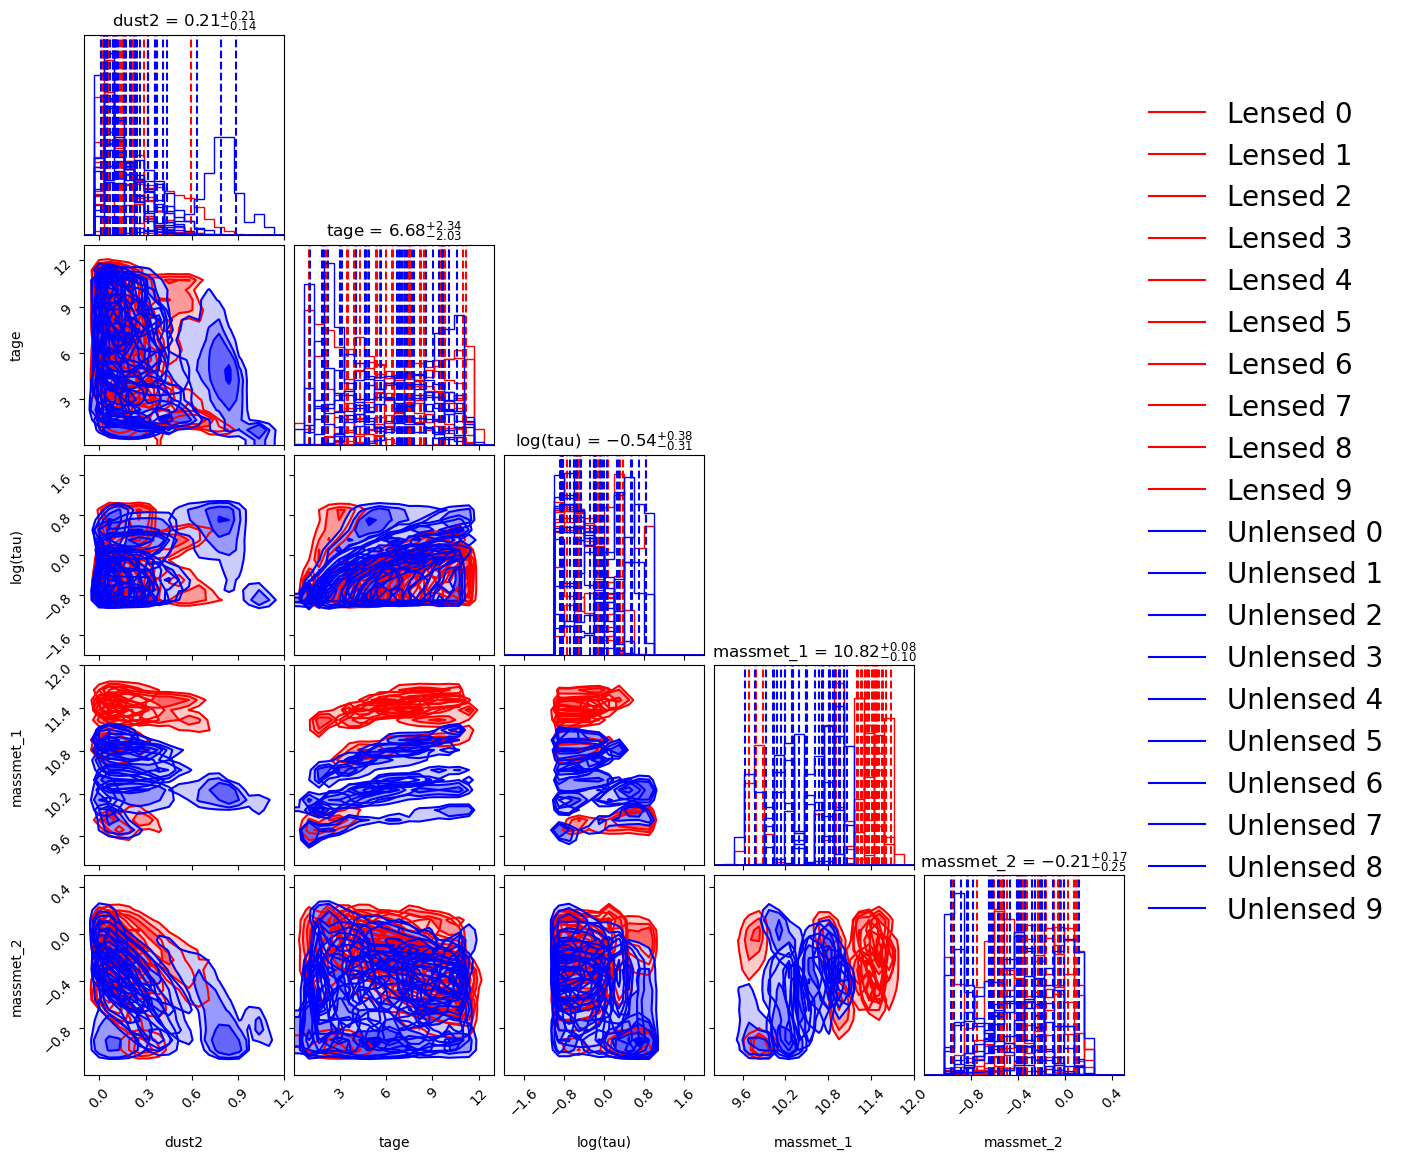

In [24]:
unlensed = [f'test_data/unlensed_param_1{i}.h5' for i in range(10)]
lensed = [f'test_data/lensed_param_1{i}.h5' for i in range(10)]
ax_range = [(-.1,1.2), (0, 13), (-2, 2), (9.2, 12), (-1.2, .5)]
make_plots_for_h5(lensed+unlensed, ax_range=ax_range,
                  labels=[f'Lensed {i}' for i in range(10)]+[f'Unlensed {i}' for i in range(10)],
                  colors=['r']*10+['b']*10, save='figs/param_test.png')

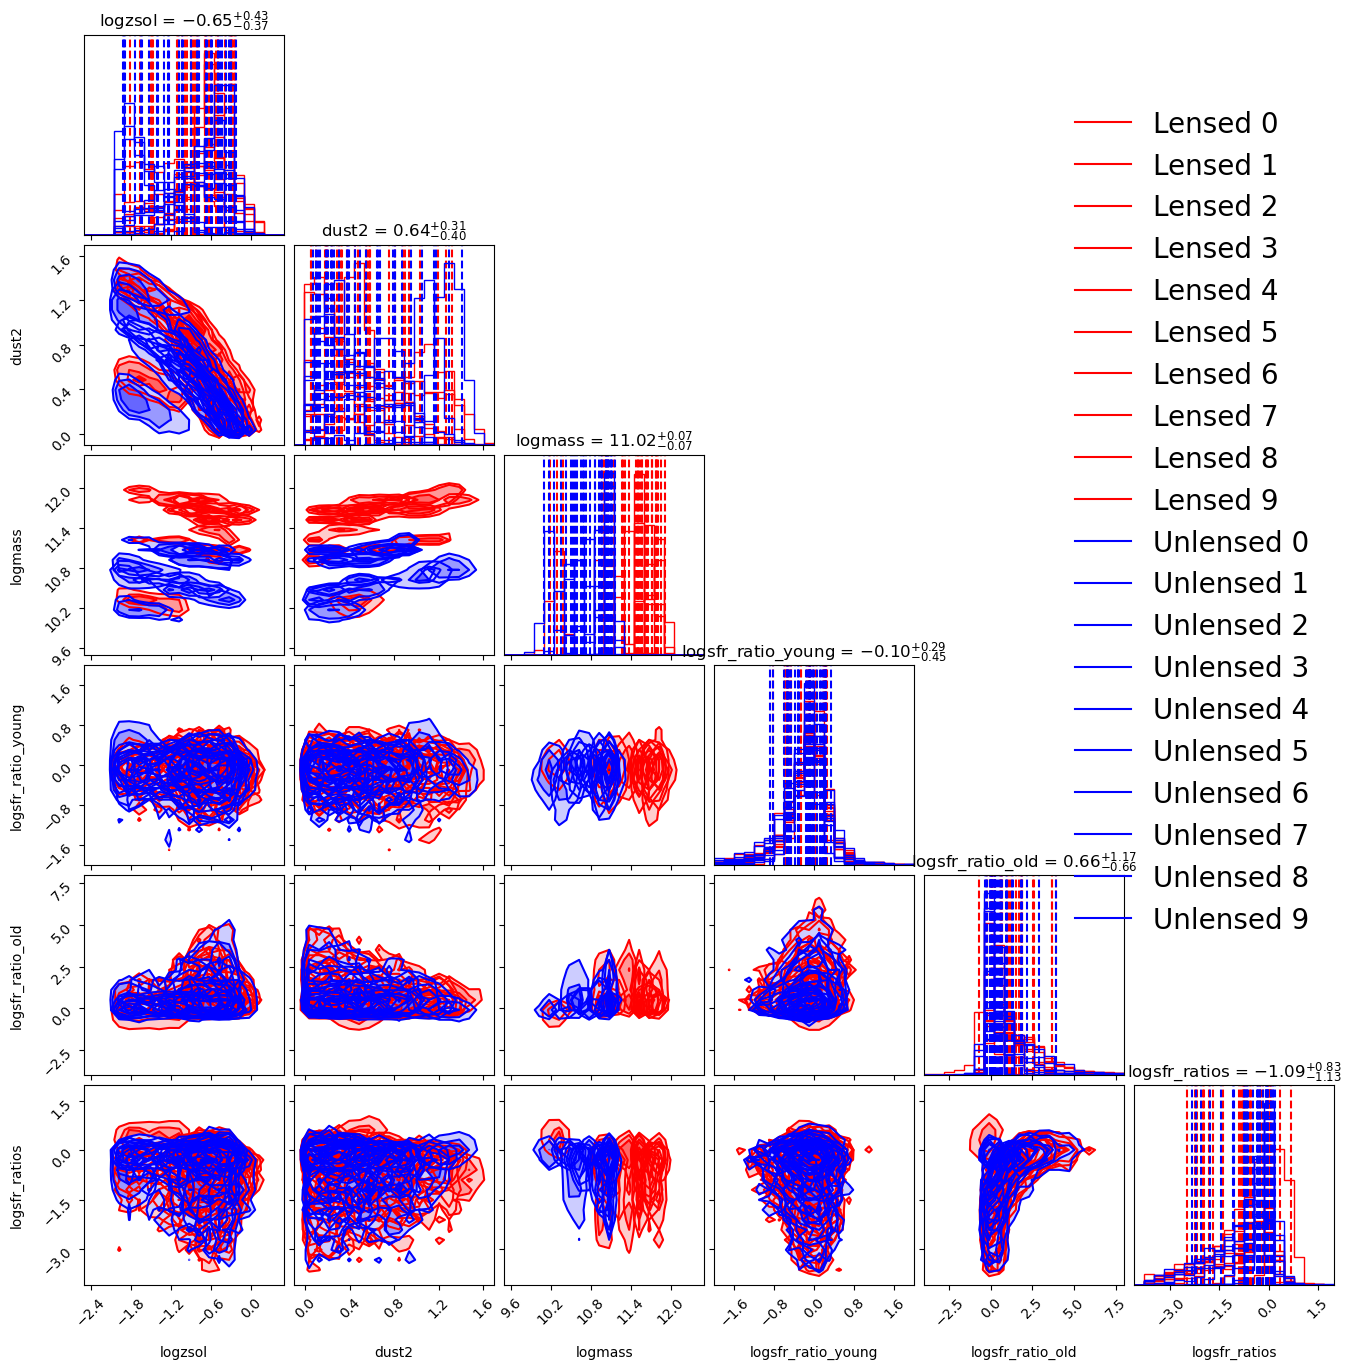

In [34]:
unlensed = [f'test_data/unlensed_nonparam_1{i}.h5' for i in range(10)]
lensed = [f'test_data/lensed_nonparam_1{i}.h5' for i in range(10)]
ax_range = [(-2.5,.5), (-.1, 1.7), (9.5, 12.5), (-2, 2), (-4, 8), (-4.1, 2)]
make_plots_for_h5(lensed+unlensed, ax_range=ax_range,
                  labels=[f'Lensed {i}' for i in range(10)]+[f'Unlensed {i}' for i in range(10)],
                  colors=['r']*10+['b']*10, save=False)

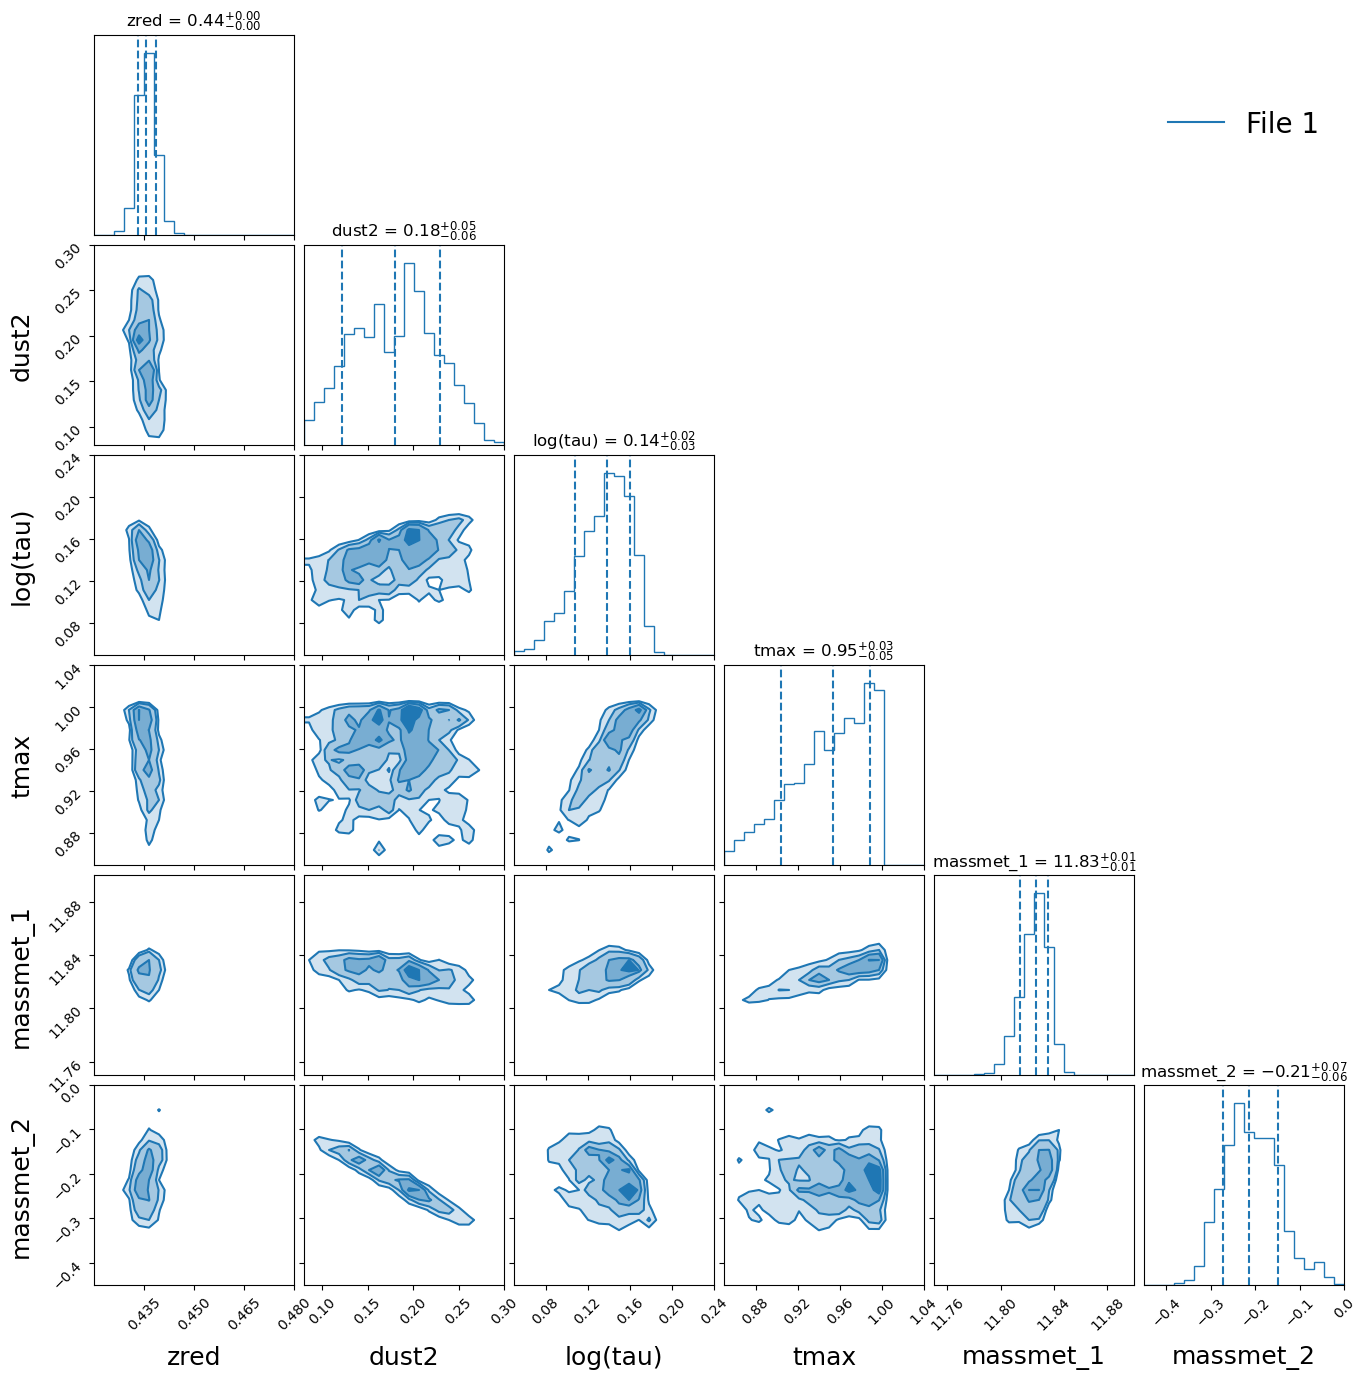

In [17]:
plt.rcParams.update({'axes.labelsize': 18})
ax_range= [(.42,.48), (0.08, 0.3), (0.05, .24), (.85, 1.04), (11.75, 11.9), (-.45, 0)]
make_plots_for_h5(lensed_h5, ax_range=ax_range, save='figs/example_h5.png')

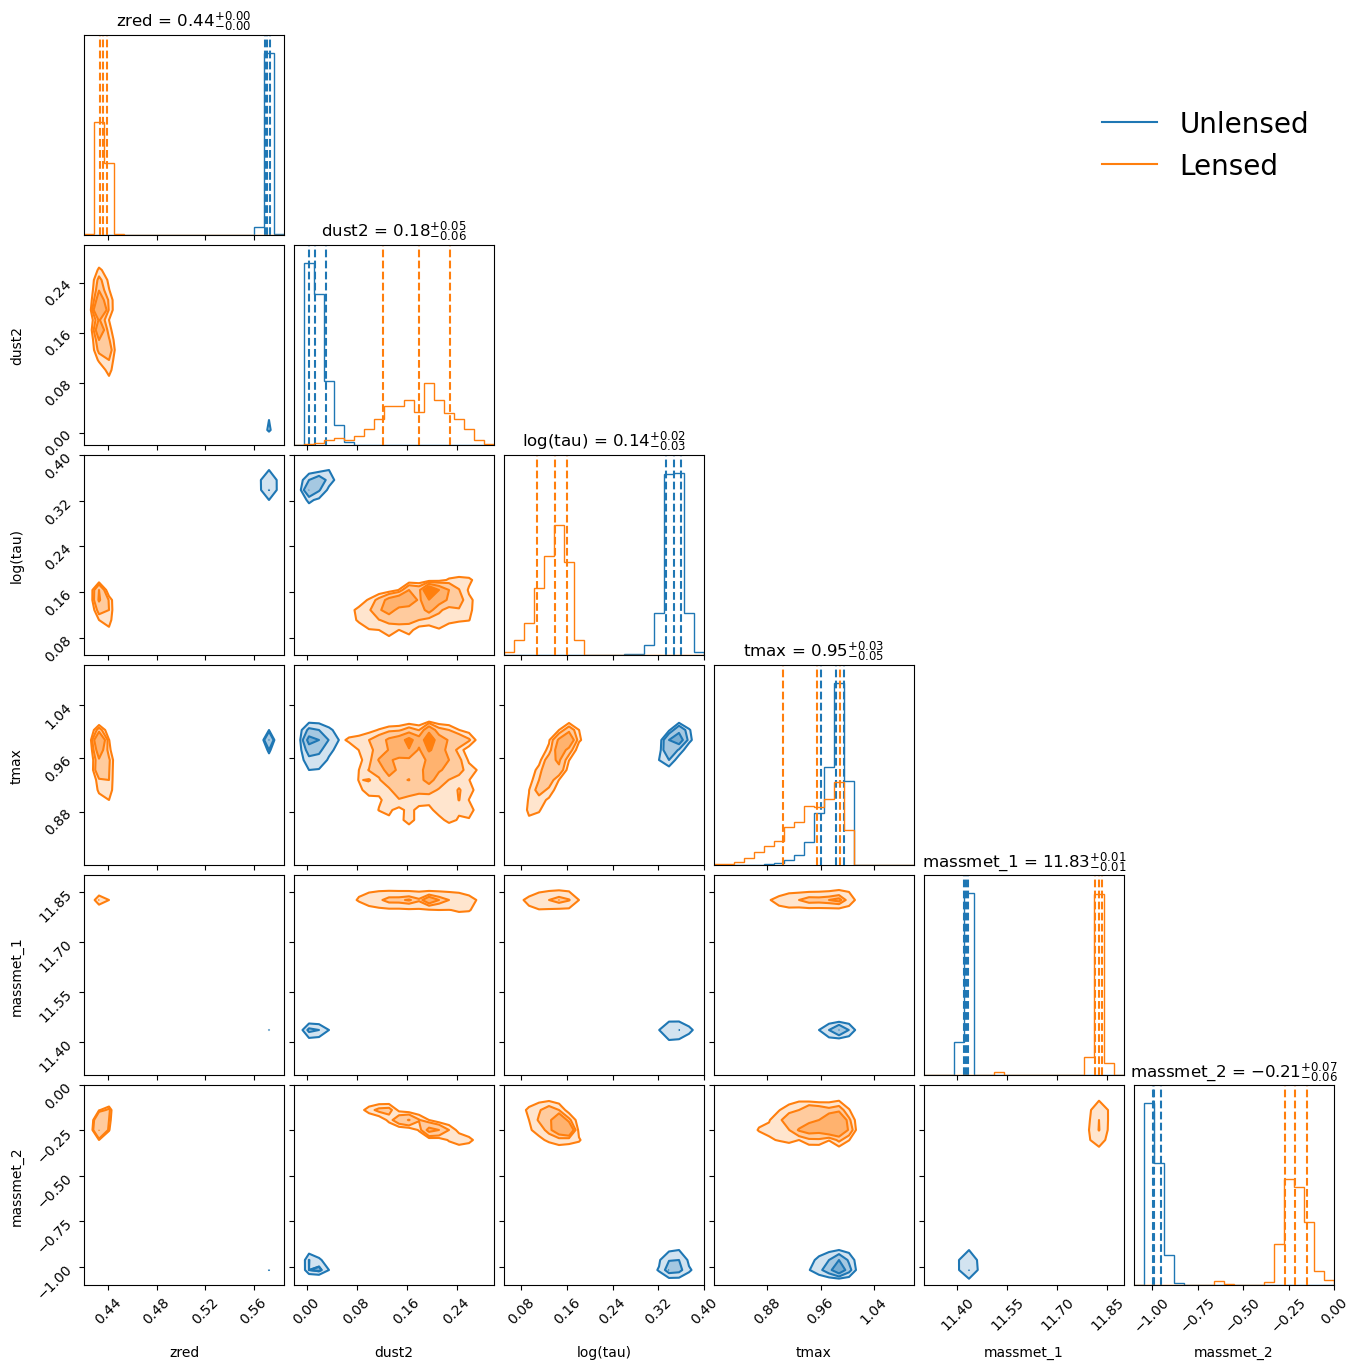

In [16]:
ax_range=[(.42,.585), (-.02, 0.3), (0.05, .4), (.8, 1.1), (11.3, 11.9), (-1.1, 0)]
make_plots_for_h5([unlensed_h5, lensed_h5], ax_range=ax_range, 
                  labels=['Unlensed', 'Lensed'], save=False)
# plt.savefig("lensed_vs_unlensed.png", bbox_inches='tight')

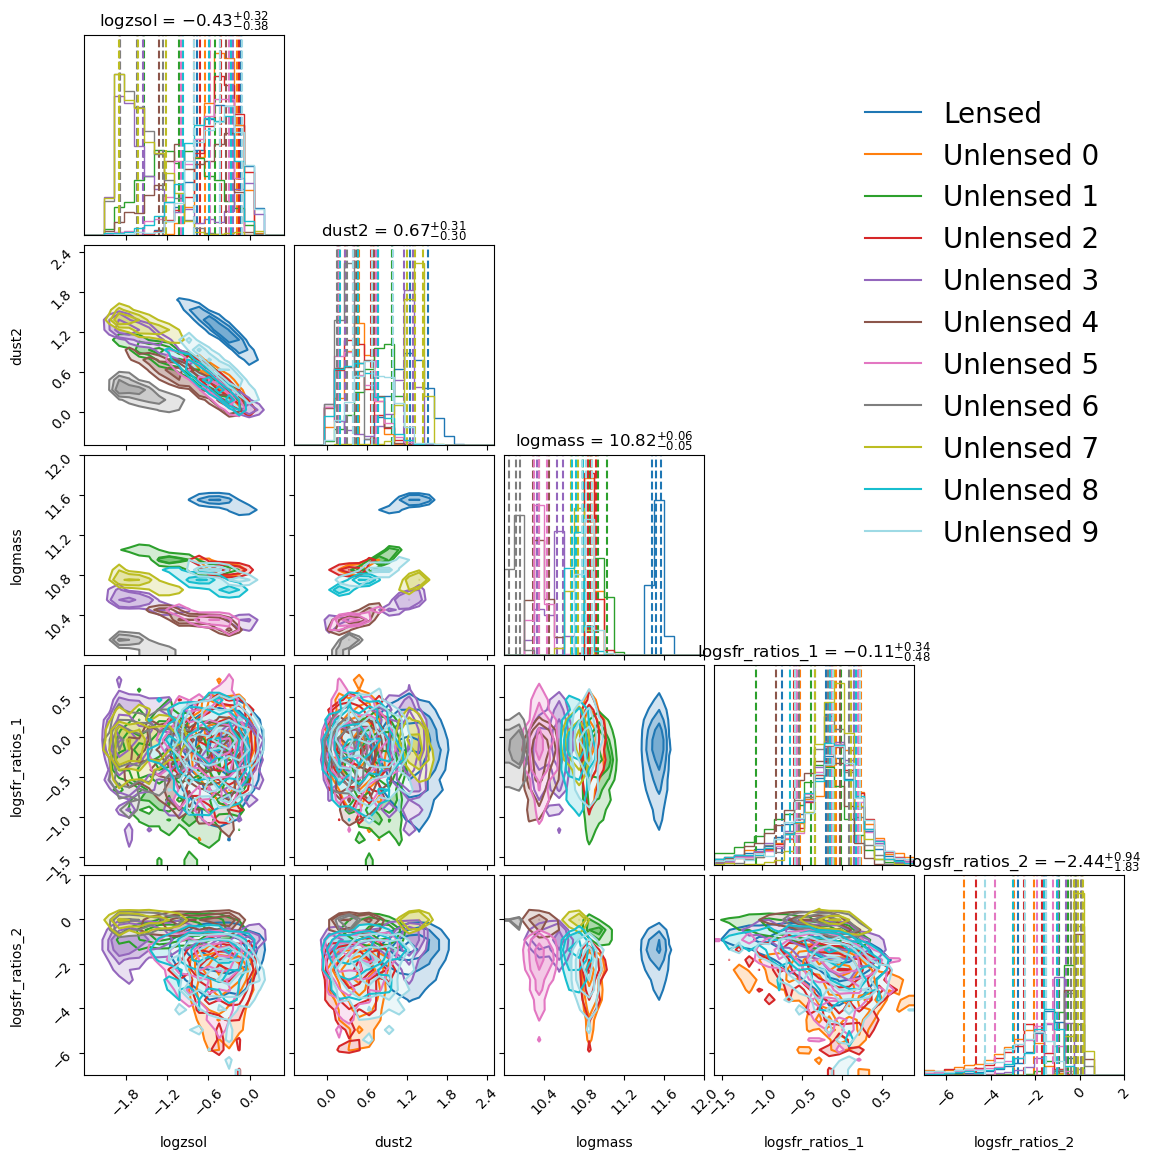

In [28]:
files = [f'unlensed_nonparam_{i}.h5' for i in range(10)]
lensed_h5 = ['lensed_nonparam_faststep_opt.h5']
# ax_range = [(0.2,.7), (-.1, .6), (-1.5, 1.5), (0, 1.5), (9, 12.5), (-1.5, .5)]
ax_range = [(-2.4,.5), (-.5,2.5), (10,12), (-1.6,.9), (-7,2)]
make_plots_for_h5(lensed_h5+files, ax_range=ax_range, save=False, 
                  labels=['Lensed']+[f'Unlensed {i}' for i in range(10)])
plt.savefig('nonparam_unlensed_vs_lensed.png', bbox_inches='tight')

# Examining block data

In [1]:
from astropy.table import Table
import os
os.environ['SPS_HOME'] = "/global/homes/e/eramey16/fsps"

from astropy.coordinates import SkyCoord
import pandas as pd

In [2]:
iptf16 = {
    'ls_id': 9906619143751091,
    'ra': 316.066215680906,
    'dec': -6.34022115158153
}

c0 = SkyCoord(iptf16['ra'], iptf16['dec'], unit='deg')
c0

<SkyCoord (ICRS): (ra, dec) in deg
    (316.06621568, -6.34022115)>

In [5]:
t = Table.read('sweep-315m065-320m060-pz.fits')
t

RELEASE,BRICKID,OBJID,Z_SPEC,SURVEY,Z_PHOT_MEAN,Z_PHOT_MEDIAN,Z_PHOT_STD,Z_PHOT_L68,Z_PHOT_U68,Z_PHOT_L95,Z_PHOT_U95,TRAINING,KFOLD,Z_PHOT_MEAN_I,Z_PHOT_MEDIAN_I,Z_PHOT_STD_I,Z_PHOT_L68_I,Z_PHOT_U68_I,Z_PHOT_L95_I,Z_PHOT_U95_I,TRAINING_I,KFOLD_I
int16,int32,int32,float32,bytes12,float32,float32,float32,float32,float32,float32,float32,bool,int16,float32,float32,float32,float32,float32,float32,float32,bool,int16
10000,32158,6845,-99.0,,0.8657983,0.80535096,0.43683046,0.5974306,1.1269373,0.07971449,2.1794171,False,3,1.0367117,0.8155859,0.9160091,0.3509207,1.8178121,0.024967108,3.9873235,False,3
10000,32158,6846,-99.0,,0.68089145,0.6528177,0.20632921,0.5434155,0.8120023,0.40415892,1.0634698,False,3,0.6709999,0.63916725,0.20946625,0.5509388,0.7511537,0.42432714,1.1387835,False,3
10000,32158,6848,-99.0,,0.8175196,0.73887885,0.47176224,0.5852009,0.92651814,0.27056584,1.9373739,False,9,0.7134939,0.676177,0.33199364,0.4701051,0.93110424,0.12809238,1.536216,False,9
10000,32158,6849,-99.0,,1.0591595,1.1087036,0.41460434,0.63381153,1.4083245,0.19391485,1.8086265,False,8,1.10617,1.1165987,0.49601537,0.5597102,1.5165402,0.22641727,2.305272,False,8
10000,32158,6850,-99.0,,0.9703792,0.9637525,0.15722115,0.8224256,1.1247473,0.67183524,1.2758932,False,8,0.88733333,0.8865156,0.12239243,0.79227626,0.9779244,0.6658065,1.1069872,False,8
10000,32158,6851,-99.0,,0.86905056,0.8467872,0.15691262,0.71975213,1.0337574,0.59934604,1.1998757,False,8,0.9128626,0.9351138,0.20344442,0.67811966,1.116325,0.5279557,1.2638532,False,8
10000,32158,6852,-99.0,,1.0262773,1.0057784,0.22228695,0.88022095,1.1494617,0.7253069,1.4475297,False,4,1.1366819,1.1124591,0.47353506,0.76390535,1.4400003,0.2195,2.384147,False,4
10000,32158,6853,-99.0,,0.41927198,0.33425525,0.22658078,0.25060415,0.6109744,0.16554436,0.98791295,False,3,0.38175872,0.3112657,0.25818813,0.23497403,0.53242356,0.1566,0.9287789,False,3
10000,32158,6854,-99.0,,0.64690554,0.60999405,0.24403718,0.4652699,0.79007095,0.37367213,1.1673274,False,2,0.62726414,0.528733,0.40288642,0.40605,0.7577052,0.31209964,2.0480673,False,2


# Color-color plots of DR9 data

In [1]:
import os
os.environ['SPS_HOME'] = "/global/homes/e/eramey16/fsps"

from docker import util
from docker import classify
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
engine = create_engine(util.conn_string)
conn = engine.connect()

In [3]:
lensed = pd.read_sql_table('lensed_dr10_phot', conn)
unlensed = pd.read_sql_table('unlensed_dr10_phot', conn)

In [4]:
# data = pd.DataFrame()
# grouped = unlensed.groupby({x: x // 100 for x in range(len(unlensed))})
colors = ['g_r', 'i_z', 'r_i', 'r_z', 'w1_w2', 'z_w1']
# for i, row in unlensed.iterrows():
#     # where = f'trac.ls_id IN ({", ".join(list(group.ls_id.astype(str)))})'
#     if i % 100 == 0: print('.',end=' ')
#     try:
#         df = classify.query_galaxy(row.ra, row.dec, cols=classify.trac_cols+colors)
#         if len(df)>1:
#             # print(f'\nMore than one! index {i}')
#             df = df.iloc[[0]]
#         data = pd.concat([data, df], ignore_index=True, copy=False)
#     except:
#         print(f"\nCouldn't add index {i}")
# data
# data.to_sql('unlensed_dr10_phot', conn, if_exists='replace')

In [5]:
# Calculate abs mag in r band
lensed['abs_mag_r'] = lensed.dered_mag_r - 5*np.log10(300000*lensed.z_phot_median/70)+25
unlensed['abs_mag_r'] = unlensed.dered_mag_r - 5*np.log10(300000*unlensed.z_phot_median/70)+25

/global/homes/e/eramey16/.conda/envs/myprospector/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


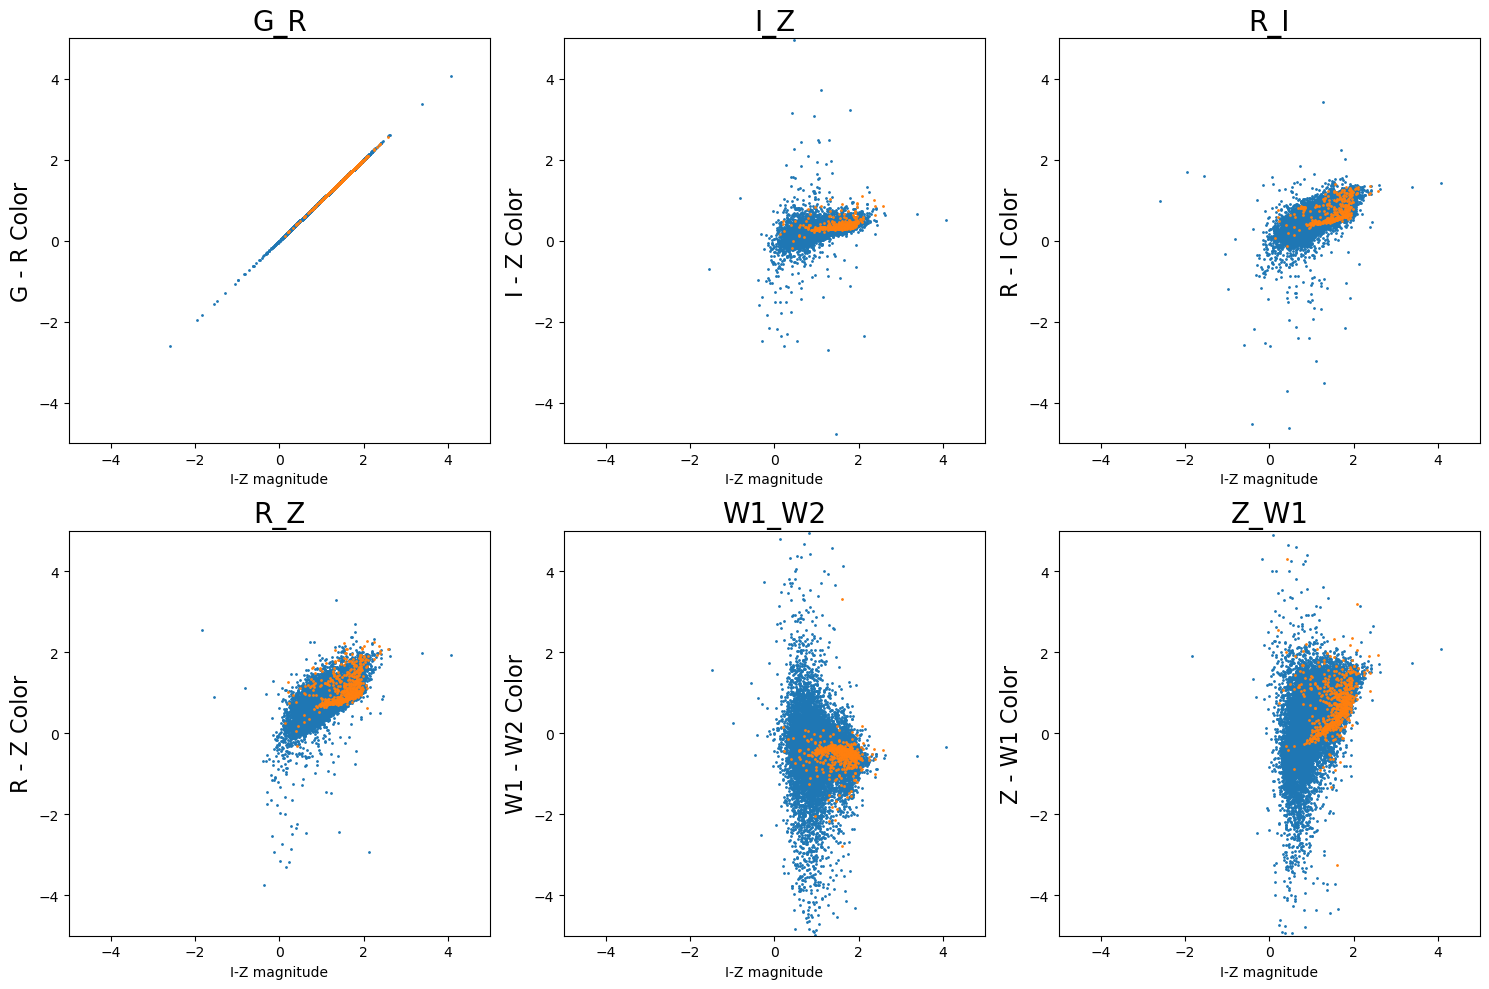

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(15,10))
for i,ax in enumerate(axes.flatten()):
    ax.plot(unlensed['g_r'], unlensed[colors[i]], '.', ms=2)
    ax.plot(lensed['g_r'], lensed[colors[i]], '.', ms=2)
    ax.set_title(f"{colors[i].upper()}", fontsize=20)
    ax.set_xlabel("I-Z magnitude")
    ax.set_ylabel(f"{colors[i].replace('_', ' - ').upper()} Color", fontsize=16)
    ax.set_ylim([-5, 5])
    ax.set_xlim([-5, 5])
plt.tight_layout()
# plt.savefig('color_vs_mag.png', bbox_inches='tight')

/global/homes/e/eramey16/.conda/envs/myprospector/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/global/homes/e/eramey16/.conda/envs/myprospector/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/global/homes/e/eramey16/.conda/envs/myprospector/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/global/homes/e/eramey16/.conda/envs/myprospector/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/global/homes/e/eramey16/.conda/envs/myprospector/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in

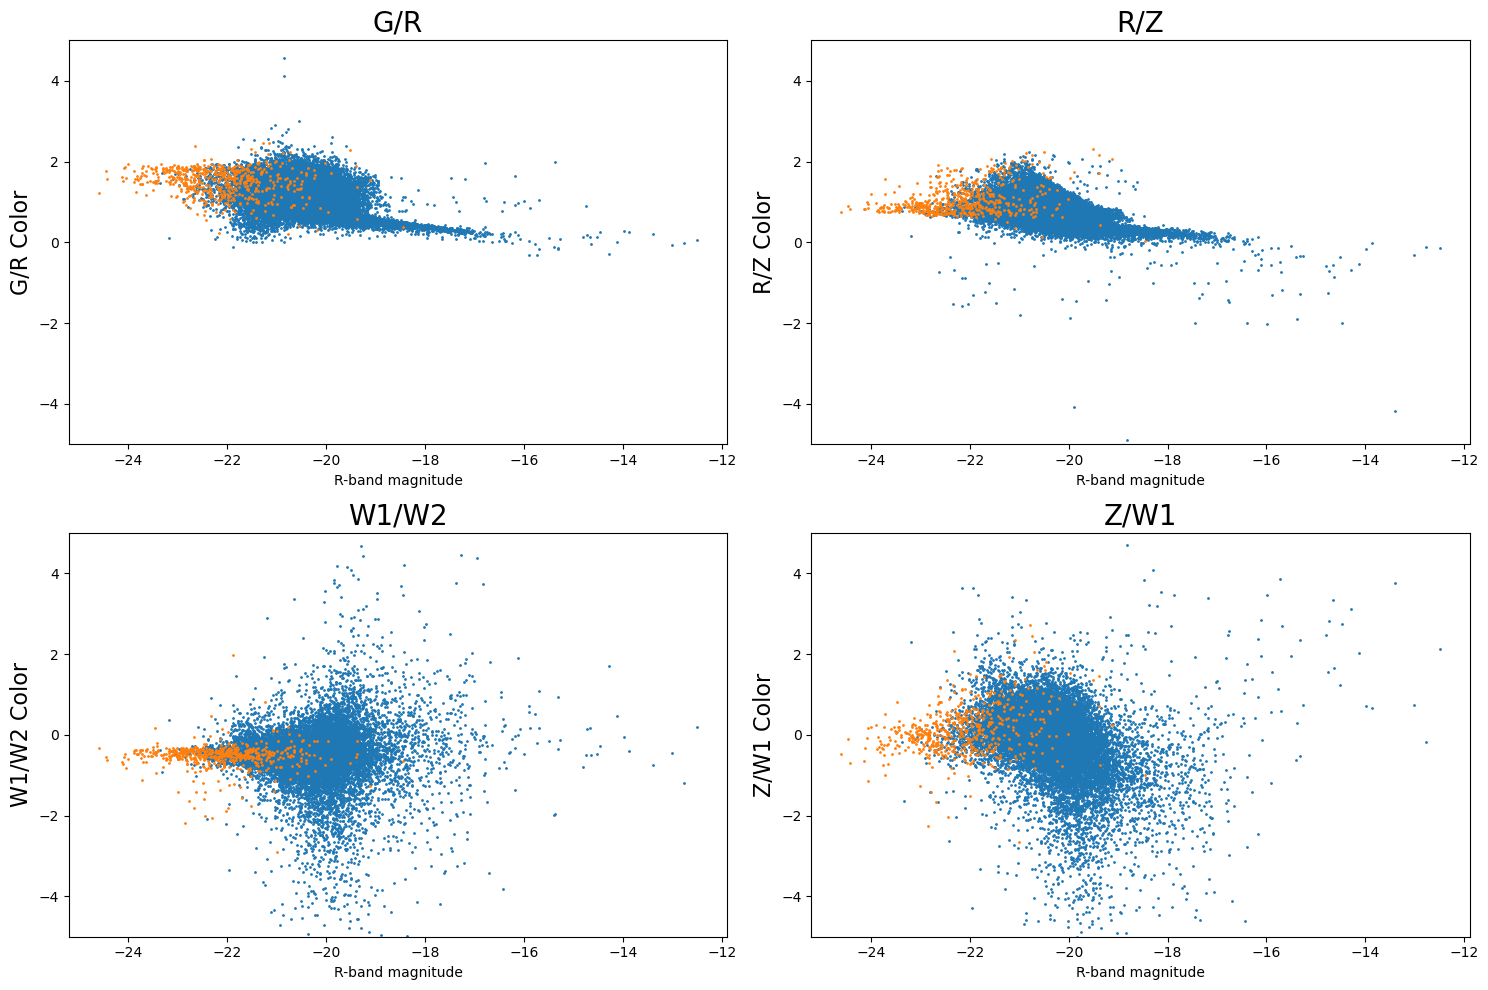

In [13]:
lensed = pd.read_sql_table('all_lensed', conn)
unlensed = pd.read_sql_table('unlensed', conn)

lensed = util.clean_and_calc(lensed, mode='dr9', i_band=False)
unlensed = util.clean_and_calc(unlensed, mode='dr9', i_band=False)
colors = ['g/r', 'r/z', 'w1/w2', 'z/w1']

fig, axes = plt.subplots(2, 2, figsize=(15,10))
for i,ax in enumerate(axes.flatten()):
    ax.plot(unlensed['abs_mag_r'], unlensed[colors[i]], '.', ms=2)
    ax.plot(lensed['abs_mag_r'], lensed[colors[i]], '.', ms=2)
    ax.set_title(f"{colors[i].upper()}", fontsize=20)
    ax.set_xlabel("R-band magnitude")
    ax.set_ylabel(f"{colors[i].replace('_', ' - ').upper()} Color", fontsize=16)
    ax.set_ylim([-5, 5])
plt.tight_layout()

In [4]:
conn.close()

In [ ]:
classify.send_query(where=f'trac.ls_id IN (10995422143187063, 9907736037035529)', cols=classify.trac_cols+colors)

In [ ]:
lensed['g_r'] = -2.5*np.log10(lensed['dered_mag_g']/lensed['dered_mag_r'])
plt.plot(lensed['g_r'], '.')